## What is a Learning Rate Scheduler?

The **learning rate (LR)** controls how big each update step is during optimization:

$$
\theta_{t+1} = \theta_t - \eta_t , \nabla_\theta \mathcal{L}(\theta_t)
$$

where $ \eta_t $ is the **learning rate at step $t$**.

A **scheduler** automatically adjusts $ \eta_t $ during training to:

* Speed up convergence early on,
* Avoid overshooting minima,
* Fine-tune learning near convergence.

---

### Setup: Basic Training Loop (Before Scheduler)

```python
import torch
import torch.nn as nn
import torch.optim as optim

# Dummy model, dataset, and loss
model = nn.Linear(10, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
```

### Basic training loop without scheduler

```python
for epoch in range(10):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
```

---

### Add a Scheduler

You create a scheduler **after** the optimizer.

**Example — StepLR**

This scheduler **decays the learning rate by a factor of `gamma` every `step_size` epochs**.

```python
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
```

Here, every `5` epochs the $LR$ will be multiplied by `0.1`.

---

### Training loop (with StepLR)

```python
for epoch in range(20):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    # Step the scheduler after each epoch
    scheduler.step()

    # Print current learning rate
    lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}: LR = {lr:.5f}")
```

**Order summary:**

1. Forward
2. Backward
3. Optimizer step
4. Scheduler step (usually once per epoch)

---

## 4. Popular Schedulers

| Scheduler             | Description                                      | Common use                          |
| --------------------- | ------------------------------------------------ | ----------------------------------- |
| **StepLR**            | Decrease LR every fixed number of epochs         | Simple training with known LR drops |
| **MultiStepLR**       | Drop LR at specified epochs                      | More flexible version of StepLR     |
| **ExponentialLR**     | Multiply LR by `gamma` every epoch               | Smooth decay                        |
| **CosineAnnealingLR** | Cosine-shaped LR curve                           | Vision Transformers, segmentation   |
| **ReduceLROnPlateau** | Decrease LR when validation loss stops improving | Adaptive scheduling                 |
| **OneCycleLR**        | Increase then decrease LR within one cycle       | Fast convergence (common for CNNs)  |
| **LambdaLR**          | Define a custom lambda function for LR           | Full control                        |

---

**Example: `ReduceLROnPlateau`**

This one is different — you call `.step(metric)` with the **validation loss** instead of every epoch.

```python
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, verbose=True
)

for epoch in range(20):
    train_one_epoch(...)
    val_loss = evaluate(...)
    
    scheduler.step(val_loss)
```

---

**`OneCycleLR`**

Used for fast and stable convergence, especially in CNNs and Transformers.

```python
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1, steps_per_epoch=len(dataloader), epochs=10
)

for epoch in range(10):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
```

Here, `.step()` is called **every batch**, not every epoch.

---

### Checking the Learning Rate Schedule

You can visualize the learning rate over time to verify it behaves as expected.

```python
import matplotlib.pyplot as plt

lrs = []

optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(20):
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()

plt.plot(range(1, 21), lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('LR schedule')
plt.show()
```

---

### Common Pitfalls

❌ Calling `scheduler.step()` **before** the first optimizer step — always step **after** optimizer update.
✅ Exception: when using **OneCycleLR**, step every iteration after `optimizer.step()`.

❌ Forgetting to pass validation loss for `ReduceLROnPlateau`.

✅ Use `scheduler.get_last_lr()` to log current LR to TensorBoard/W&B.

---

###  Quick Comparison Table

| Scheduler         | Step When | Input Needed    | LR Behavior              |
| ----------------- | --------- | --------------- | ------------------------ |
| StepLR            | epoch     | none            | abrupt drops             |
| MultiStepLR       | epoch     | none            | controlled drops         |
| ExponentialLR     | epoch     | none            | smooth exponential decay |
| ReduceLROnPlateau | epoch     | validation loss | adaptive decay           |
| OneCycleLR        | batch     | none            | cyclic pattern           |
| CosineAnnealingLR | epoch     | none            | smooth cosine decay      |

---


## **Best Practices**

### 1. **Understand the goal of your scheduler**

Schedulers aren’t magic — they’re a way to **control the learning dynamics**:

| Goal                                                        | Scheduler Type                                       | Why                                |
| ----------------------------------------------------------- | ---------------------------------------------------- | ---------------------------------- |
| Fast convergence at start, small steps near minima          | **StepLR**, **ExponentialLR**, **CosineAnnealingLR** | Reduces overshooting               |
| Avoid getting stuck in local minima                         | **CosineAnnealingLR**, **OneCycleLR**                | Uses cyclical or smooth schedules  |
| Dynamically adapt to validation loss                        | **ReduceLROnPlateau**                                | Reduces LR when learning stagnates |
| Highly tuned training for large models (Transformers, ViTs) | **CosineAnnealingWarmRestarts** or **OneCycleLR**    | Smooth control of LR dynamics      |

---

###  2. **Call order matters**

Always follow this inside your loop:

```python
optimizer.zero_grad()
loss = criterion(model(inputs), targets)
loss.backward()
optimizer.step()
scheduler.step()  # after optimizer.step()
```

Exceptions:

* **OneCycleLR** → step **every batch** (not every epoch)
* **ReduceLROnPlateau** → step **after validation**, with `scheduler.step(val_loss)`

---

###  3. **Common default heuristics**

| Scenario                      | Recommended Scheduler                         | Base LR                             |
| ----------------------------- | --------------------------------------------- | ----------------------------------- |
| Simple CNN, small dataset     | `StepLR(step_size=10, gamma=0.1)`             | 1e-2 or 1e-3                        |
| ResNet / UNet training        | `CosineAnnealingLR(T_max=epochs)`             | 1e-3                                |
| Transformer / ViT             | `CosineAnnealingWarmRestarts` or `OneCycleLR` | use warmup start: e.g., 1e-4 → 1e-3 |
| Fine-tuning pretrained model  | `ReduceLROnPlateau`                           | start smaller (1e-4)                |
| Very large batch size (>1024) | `OneCycleLR`                                  | can start higher, e.g., 1e-2        |

---

### 4. **Warm-up phase**

Large models (especially Transformers, Vision Transformers, or very deep CNNs) often fail to converge if the learning rate starts too high.

Use a **warm-up** scheduler — start with a small LR and gradually increase:

$$
\eta_t = \eta_{\text{max}} \times \frac{t}{t_\text{warmup}}
$$

Implementation:

```python
from torch.optim.lr_scheduler import LambdaLR

def warmup_linear_lr(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return 1.0  # keep LR constant after warmup

scheduler = LambdaLR(optimizer, lr_lambda=warmup_linear_lr)
```

Or use `OneCycleLR` (it includes warm-up automatically).

---

###  5. **Log and visualize your learning rate**

Track the LR every epoch or batch — for example, with W&B or TensorBoard:

```python
lr = scheduler.get_last_lr()[0]
wandb.log({'learning_rate': lr})
```

Or plot it to ensure your schedule behaves as expected.

---

### 6. **Do not over-schedule**

If you reduce the LR too early or too aggressively:

* The model might get stuck in a suboptimal local minimum.
* Training might become too slow.

**Tip:** Watch the training and validation loss.
If both flatten out together → fine.
If training keeps improving but validation does not → use `ReduceLROnPlateau`.

---

### 7. **Practical recipe**

For most models (CNNs, UNets, ViTs):

1. Start with a **moderate initial LR** (1e-3 or 1e-4).
2. Use **CosineAnnealingLR** or **OneCycleLR** for smooth decay.
3. Add **warm-up** if the model or dataset is large.
4. If training stalls, switch to **ReduceLROnPlateau**.

---

### 8. **Inspect learning rate range (LR finder)**

A powerful trick: use the **Learning Rate Finder** to automatically discover a good LR range.

In fastai or manual implementation:

* Gradually increase LR from 1e-7 → 1e-1 during a few mini-batches.
* Plot loss vs LR.
* Choose LR slightly before loss starts increasing.

Example:
If loss drops fastest around 1e-3 → that’s your sweet spot.

---

###  9. **Batch-based vs epoch-based schedulers**

| Scheduler                     | Step Frequency            | Typical Use                     |
| ----------------------------- | ------------------------- | ------------------------------- |
| `StepLR`, `CosineAnnealingLR` | per **epoch**             | small to medium datasets        |
| `OneCycleLR`, `CyclicLR`      | per **batch**             | large datasets, fine LR control |
| `ReduceLROnPlateau`           | per **epoch (after val)** | validation-driven control       |

---

###  10. **Combine schedulers**

You can chain schedulers for complex schedules, for example:

* Warm-up for 5 epochs
* Then cosine annealing

```python
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

scheduler = SequentialLR(
    optimizer,
    schedulers=[
        LinearLR(optimizer, start_factor=0.01, total_iters=5),
        CosineAnnealingLR(optimizer, T_max=95)
    ],
    milestones=[5]
)
```

---

## Summary of Rules of Thumb

| Rule                                 | Explanation                                             |
| ------------------------------------ | ------------------------------------------------------- |
| **Always decay LR**                  | Don’t train with constant LR unless you monitor closely |
| **Use warmup for Transformers/ViTs** | Prevents unstable gradients early on                    |
| **Validate at every epoch**          | Needed if using `ReduceLROnPlateau`                     |
| **Visualize LR curve**               | To debug scheduling problems                            |
| **Match step frequency**             | `.step()` placement depends on scheduler type           |
| **Avoid too many drops**             | Over-decay → underfitting                               |
| **Try CosineAnnealingLR first**      | Works well in most cases                                |

---


## **Learning Rate Scheduling** and **Weight Decay**

**learning rate scheduling** and **weight decay** are related in that both affect *how parameters are updated*, but they control **different mechanisms**.

---

### 1. The optimization update equation

In most optimizers (like SGD or Adam), each parameter update looks like this:

$$
\theta_{t+1} = \theta_t - \eta_t , (\nabla_\theta \mathcal{L}(\theta_t) + \lambda , \theta_t)
$$

where:

* $ \eta_t $ → learning rate (possibly scheduled over time)
* $ \lambda $ → weight decay ($L2$ regularization term)
* $ \nabla_\theta \mathcal{L} $ → gradient of the loss

---

### 2. What each term does

| Concept           | Symbol                 | Effect                                                       | Controlled by                 |
| ----------------- | ---------------------- | ------------------------------------------------------------ | ----------------------------- |
| **Learning rate** | $ \eta_t $             | Scales the *step size* — how far parameters move each update | `optimizer.lr` + scheduler    |
| **Weight decay**  | $ \lambda , \theta_t $ | Penalizes large weights (shrinks them towards zero)          | `optimizer(weight_decay=...)` |

So:

* **Learning rate:** controls *speed* of learning.
* **Weight decay:** controls *magnitude* of parameters (regularization).

---

### 3. How they interact

They **multiply each other** during the update step.
A scheduler changes $\eta_t $ over time, so the *effective strength* of weight decay also changes proportionally.

For example, if you use a `StepLR` or `CosineAnnealingLR`:

$$
\text{effective regularization} = \eta_t , \lambda
$$

When your LR decreases, the overall regularization effect becomes weaker — because both the gradient and weight decay terms are scaled by the learning rate.

---

### 4. Practical intuition

| Phase                    | Learning Rate | Effect on Weight Decay |
| ------------------------ | ------------- | ---------------------- |
| Early training (high LR) | Large steps   | Stronger shrinkage     |
| Late training (low LR)   | Small steps   | Weaker shrinkage       |

So scheduling the LR indirectly affects how strong weight decay feels through training — even if `weight_decay` itself stays constant.

---

### 5. Modern optimizers: decoupled weight decay (AdamW)

Older Adam/SGD implementations *mix* weight decay with gradient scaling.
**AdamW** (and similar optimizers) *decouple* them:

$$
\theta_{t+1} = (1 - \eta_t \lambda) , \theta_t - \eta_t , \nabla_\theta \mathcal{L}(\theta_t)
$$

Here:

* Weight decay acts **independently** of gradient scale.
* This gives more predictable regularization, especially with LR schedulers.

That’s why **AdamW** is now standard for deep learning.

**If you use a scheduler, always prefer AdamW (not Adam) when weight decay is important.**

---

### 6. Practical tuning tips

| Tip                                  | Explanation                                                  |
| ------------------------------------ | ------------------------------------------------------------ |
| Keep `weight_decay` constant         | It’s usually fixed (e.g. 1e-4 or 1e-5) while LR changes      |
| LR scheduling affects decay strength | Lower LR → smaller effective regularization                  |
| For ViT / Transformers               | Common: `lr=3e-4`, `weight_decay=0.05`, `scheduler=cosine`   |
| For CNNs                             | Common: `lr=1e-3`, `weight_decay=1e-4`, `scheduler=StepLR`   |
| Never decay bias or norm weights     | Exclude `bias` and `BatchNorm` from weight decay (see below) |

---

### 7. Excluding certain parameters from weight decay

Often you don’t want to regularize biases or normalization parameters:

```python
decay, no_decay = [], []
for name, param in model.named_parameters():
    if 'bias' in name or 'norm' in name:
        no_decay.append(param)
    else:
        decay.append(param)

optimizer = torch.optim.AdamW([
    {'params': decay, 'weight_decay': 1e-4},
    {'params': no_decay, 'weight_decay': 0.0}
], lr=1e-3)
```

---

### 8. Summary

| Concept           | Controls            | Typical Value                   | Scheduler interaction     |
| ----------------- | ------------------- | ------------------------------- | ------------------------- |
| **Learning rate** | Step size           | 1e-4 – 1e-2                     | Changes dynamically       |
| **Weight decay**  | Regularization (L2) | 1e-5 – 1e-3                     | Indirectly affected by LR |
| **Optimizer**     | Update rule         | AdamW, SGD                      | Applies both terms        |
| **Scheduler**     | LR evolution        | StepLR, CosineAnnealingLR, etc. | Changes only LR, not λ    |

---

# 1. Most common LR schedulers (ranked)

## 1. StepLR / MultiStepLR

**Most widely used for classical CNNs (ResNet, VGG, EfficientNet).**

### How it works

Reduces learning rate by a factor ( \gamma ) every fixed number of epochs.

### Equation

If the base learning rate is ( \eta_0 ), after ( k = \lfloor \tfrac{t}{\text{step_size}} \rfloor ):

$$
\eta_t = \eta_0 \cdot \gamma^{k}
$$

MultiStepLR is the same but steps at a list of epochs.

---

## 2. ExponentialLR

### Equation

$$
\eta_t = \eta_0 \cdot \gamma^{,t}
$$

Decreases smoothly every epoch.

---

## 3. Cosine Annealing (CosineAnnealingLR)

**Most common in Transformers, ViT, ConvNeXt, MAE, LLaMA-style training.**

### Equation

If total epochs are ( T ), and ( t ) is current epoch:

$$
\eta_t = \eta_{\min} + \frac{1}{2} (\eta_0 - \eta_{\min}) \left(1 + \cos\frac{\pi t}{T}\right)
$$

Gives a smooth cosine curve. No abrupt jumps.

---

## 4. Cosine Annealing with Warm Restarts (SGDR)

### Equation

Resets periodically: for cycle ( i ) with length ( T_i ):

$$
\eta_t = \eta_{\min} + \frac{1}{2} (\eta_0 - \eta_{\min}) \left(1 + \cos\frac{\pi (t - T_{\text{start}})}{T_i}\right)
$$

Common in large-scale training.

---

## 5. Linear Warmup + Something (most common in modern DL)

Used in Transformer, ViT, GPT, diffusion models, CLIP training.

### Warmup

For warmup steps ( w ):

$$
\eta_t = \eta_0 \cdot \frac{t}{w}, \quad t \le w
$$

After warmup, you switch to a scheduler (cosine, polynomial, constant).

---

## 6. ReduceLROnPlateau

**Most used in Keras and PyTorch training when validation loss is unstable.**

### How it works

Monitors a metric (val loss).
Reduces LR by factor ( \gamma ) if metric has not improved for ( p ) epochs.

### Equation

Not analytical; conceptually:

$$
\eta_{t+1} =
\begin{cases}
\gamma,\eta_t & \text{if no improvement for } p \text{ epochs} \
\eta_t & \text{otherwise}
\end{cases}
$$

---

## 7. Polynomial decay (PolyLR)

Very common in segmentation models (DeepLab, HRNet, etc).

### Equation

For power ( p ):

$$
\eta_t = \eta_0, \left(1 - \frac{t}{T}\right)^p
$$

---

## 8. OneCycleLR

Used in fastai, YOLO training.

### Phases

1. Linear increase
2. Cosine/linear decrease
3. Optional annealing at the end

### Equation

Piecewise, but core idea:

$$
\eta_t \uparrow \text{then} \downarrow
$$

Improves generalization.

---

## 9. CyclicLR

Oscillates between minimum and maximum LR.

### Equation

Triangular wave or cosine wave between ( \eta_{\min} ) and ( \eta_{\max} ).

---

## 10. LambdaLR

User-defined LR: any function you define:

$$
\eta_t = \eta_0 \cdot \lambda(t)
$$

---

## 11. ConstantLR

Keeps LR constant for a portion of training, then steps.

---

## 12. Inverse Square Root (Transformer LR)

Used in original Transformer, T5, BART.

### Equation

Used after warmup:

$$
\eta_t = \frac{1}{\sqrt{t}}
$$

More precisely:

$$
\eta_t = d^{-0.5} \cdot \min(t^{-0.5}, t \cdot w^{-1.5})
$$

where ( d ) is the model dimension, ( w ) warmup steps.

---

# 2. Summary Table (ranked by real-world usage)

| Rank | Scheduler          | Usage                    |
| ---- | ------------------ | ------------------------ |
| 1    | StepLR             | Classic vision models    |
| 2    | Cosine Annealing   | Transformers, ViT        |
| 3    | Warmup + Cosine    | GPT, ViT, diffusion      |
| 4    | ReduceLROnPlateau  | Keras, unstable training |
| 5    | ExponentialLR      | Classic ML, simple CNN   |
| 6    | Polynomial         | Segmentation             |
| 7    | OneCycleLR         | YOLO, fastai             |
| 8    | CyclicLR           | General                  |
| 9    | Linear Warmup only | Large models             |
| 10   | LambdaLR           | Custom behaviors         |

---

# 3. How to plot any scheduler

You can easily **plot LR vs epoch** or **LR vs training error** or **LR vs validation loss** by manually calling the scheduler each epoch.

Example: **plot learning rate vs epoch** for any PyTorch scheduler:



/home/behnam/anaconda3/envs/PyTorchTutorial/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


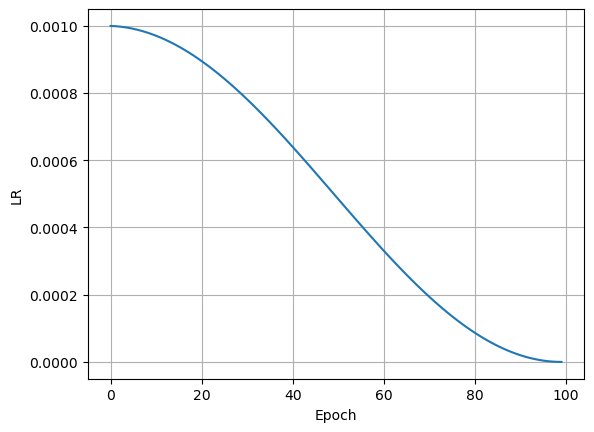

In [1]:
import torch
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam([torch.zeros(1)], lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

lrs = []
for epoch in range(100):
    scheduler.step()
    lrs.append(optimizer.param_groups[0]["lr"])

plt.plot(lrs)
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True)
plt.show()

```

---

# 4. Plot LR vs validation loss (Plateau scheduler example)

```python
import matplotlib.pyplot as plt

epochs = list(range(len(val_losses)))
lrs = logged_learning_rates  # you log lr each epoch

plt.plot(epochs, val_losses, label="val loss")
plt.plot(epochs, lrs, label="learning rate")
plt.legend()
plt.grid(True)
plt.show()
```

You can also plot LR vs training loss in the same way.

---

# 5. Example: visualizing warmup + cosine

```python
import numpy as np
import matplotlib.pyplot as plt

eta0 = 1e-3
eta_min = 1e-6
T = 100
warmup = 10

lr_values = []
for t in range(T):
    if t < warmup:
        lr = eta0 * t / warmup
    else:
        lr = eta_min + 0.5*(eta0 - eta_min)*(1 + np.cos(np.pi*(t-warmup)/(T-warmup)))
    lr_values.append(lr)

plt.plot(lr_values)
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.show()
```

---

# 6. Which scheduler should you use?

### For CNNs (classification)

• StepLR
• CosineAnnealingLR
• OneCycleLR

### For segmentation

• Polynomial decay
• Cosine
• StepLR

### For Transformer, ViT, GPT

• Warmup + Cosine
• Inverse Square Root
• Linear warmup + constant for fine-tuning

### For unstable datasets

• ReduceLROnPlateau

---

If you want, I can generate **plots for all schedulers** or give you **a single notebook that visualizes all LR curves**.